Enter the length of the beam in m:
6
Enter the number of point loads:
3
Enter load in KN 
DOWNWARD= POSITIVE
UPWARD = NEGATIVE:
 15
Enter the position in m measured from left : 1
Enter load in KN 
DOWNWARD= POSITIVE
UPWARD = NEGATIVE:
 15
Enter the position in m measured from left : 4
Enter load in KN 
DOWNWARD= POSITIVE
UPWARD = NEGATIVE:
 10
Enter the position in m measured from left : 6
Enter the number of moment:
0
Enter the number of UDLs:
1
Enter load in KN/m 
DOWNWARD= POSITIVE
UPWARD = NEGATIVE:
 20
Enter the starting point in m measured from left: 2
Enter the ending point in m measured from left: 3
Enter the number of UVLs:
0
Enter the number of fixed supports:
0
Enter the number of pin supports:
2
Enter the location in m:
0
Enter the location in m:
5
Enter the number of roller supports:
0
BEAM DIAGRAM


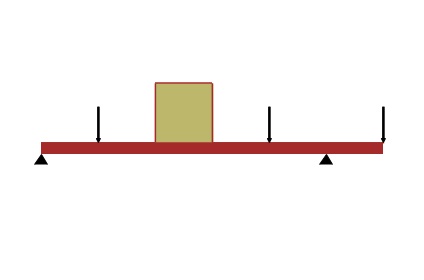

FINAL LOAD EQUATION


In [25]:
from sympy.core import S, Symbol, diff, symbols
from sympy.solvers import linsolve
from sympy.printing import sstr
from sympy.functions import SingularityFunction, Piecewise, factorial
from sympy.core import sympify
from sympy.integrals import integrate
from sympy.series import limit
from sympy.plotting import plot, PlotGrid
from sympy.geometry.entity import GeometryEntity
from sympy.external import import_module
from sympy import lambdify, Add
from sympy.core.compatibility import iterable
from sympy.utilities.decorator import doctest_depends_on
numpy = import_module('numpy', import_kwargs={'fromlist':['arange']})

class Beam:
    def __init__(self, length, elastic_modulus, second_moment, area=Symbol('A'), variable=Symbol('x'), base_char='C'):
        
        self.length = length
        self.elastic_modulus = elastic_modulus
        if isinstance(second_moment, GeometryEntity):
            self.cross_section = second_moment
        else:
            self.cross_section = None
            self.second_moment = second_moment
        self.variable = variable
        self._base_char = base_char
        self._boundary_conditions = {'deflection': [], 'slope': []}
        self._load = 0
        self._area = area
        self._applied_supports = []
        self._support_as_loads = []
        self._applied_loads = []
        self._reaction_loads = {}
        self._composite_type = None
        self._hinge_position = None

    def __str__(self):
        shape_description = self._cross_section if self._cross_section else self._second_moment
        str_sol = 'Beam({}, {}, {})'.format(sstr(self._length), sstr(self._elastic_modulus), sstr(shape_description))
        return str_sol

    @property
    def reaction_loads(self):
        """ Returns the reaction forces in a dictionary."""
        return self._reaction_loads

    @property
    def length(self):
        """Length of the Beam."""
        return self._length

    @length.setter
    def length(self, l):
        self._length = sympify(l)

    @property
    def area(self):
        """Cross-sectional area of the Beam. """
        return self._area

    @area.setter
    def area(self, a):
        self._area = sympify(a)

    @property
    def variable(self):
        
        return self._variable

    @variable.setter
    def variable(self, v):
        if isinstance(v, Symbol):
            self._variable = v
        else:
            raise TypeError("""The variable should be a Symbol object.""")

    @property
    def elastic_modulus(self):
        """Young's Modulus of the Beam. """
        return self._elastic_modulus

    @elastic_modulus.setter
    def elastic_modulus(self, e):
        self._elastic_modulus = sympify(e)

    @property
    def second_moment(self):
        """Second moment of area of the Beam. """
        return self._second_moment

    @second_moment.setter
    def second_moment(self, i):
        self._cross_section = None
        if isinstance(i, GeometryEntity):
            raise ValueError("To update cross-section geometry use `cross_section` attribute")
        else:
            self._second_moment = sympify(i)

    @property
    def cross_section(self):
        """Cross-section of the beam"""
        return self._cross_section

    @cross_section.setter
    def cross_section(self, s):
        if s:
            self._second_moment = s.second_moment_of_area()[0]
        self._cross_section = s

    @property
    def boundary_conditions(self):
        
        return self._boundary_conditions

    @property
    def bc_slope(self):
        return self._boundary_conditions['slope']

    @bc_slope.setter
    def bc_slope(self, s_bcs):
        self._boundary_conditions['slope'] = s_bcs

    @property
    def bc_deflection(self):
        return self._boundary_conditions['deflection']

    @bc_deflection.setter
    def bc_deflection(self, d_bcs):
        self._boundary_conditions['deflection'] = d_bcs

    
    def apply_support(self, loc, type="fixed"):
        
        loc = sympify(loc)
        self._applied_supports.append((loc, type))
        if type == "pin" or type == "roller":
            reaction_load = Symbol('R_'+str(loc))
            self.apply_load(reaction_load, loc, -1)
            self.bc_deflection.append((loc, 0))
        else:
            reaction_load = Symbol('R_'+str(loc))
            reaction_moment = Symbol('M_'+str(loc))
            self.apply_load(reaction_load, loc, -1)
            self.apply_load(reaction_moment, loc, -2)
            self.bc_deflection.append((loc, 0))
            self.bc_slope.append((loc, 0))
            self._support_as_loads.append((reaction_moment, loc, -2, None))

        self._support_as_loads.append((reaction_load, loc, -1, None))

    def apply_load(self, value, start, order, end=None):
        
        x = self.variable
        value = sympify(value)
        start = sympify(start)
        order = sympify(order)

        self._applied_loads.append((value, start, order, end))
        self._load += value*SingularityFunction(x, start, order)

        if end:
            # load has an end point within the length of the beam.
            self._handle_end(x, value, start, order, end, type="apply")

    

    def _handle_end(self, x, value, start, order, end, type):
        
        if order.is_negative:
            msg = ("If 'end' is provided the 'order' of the load cannot "
                    "be negative, i.e. 'end' is only valid for distributed "
                    "loads.")
            raise ValueError(msg)
        # NOTE : A Taylor series can be used to define the summation of
        # singularity functions that subtract from the load past the end
        # point such that it evaluates to zero past 'end'.
        f = value*x**order

        if type == "apply":
            # iterating for "apply_load" method
            for i in range(0, order + 1):
                self._load -= (f.diff(x, i).subs(x, end - start) *
                                SingularityFunction(x, end, i)/factorial(i))
        elif type == "remove":
            # iterating for "remove_load" method
            for i in range(0, order + 1):
                    self._load += (f.diff(x, i).subs(x, end - start) *
                                    SingularityFunction(x, end, i)/factorial(i))


    @property
    def load(self):
        
        return self._load

    @property
    def applied_loads(self):
        
        return self._applied_loads

   
    def solve_for_reaction_loads(self, *reactions):
        
        if self._composite_type == "hinge":
            return self._solve_hinge_beams(*reactions)

        x = self.variable
        l = self.length
        C3 = Symbol('C3')
        C4 = Symbol('C4')

        shear_curve = limit(self.shear_force(), x, l)
        moment_curve = limit(self.bending_moment(), x, l)

        slope_eqs = []
        deflection_eqs = []
        print(slope_eqs)
        print(deflection_eqs)

        slope_curve = integrate(self.bending_moment(), x) + C3
        for position, value in self._boundary_conditions['slope']:
            eqs = slope_curve.subs(x, position) - value
            slope_eqs.append(eqs)
            print(eqs)

        deflection_curve = integrate(slope_curve, x) + C4
        for position, value in self._boundary_conditions['deflection']:
            eqs = deflection_curve.subs(x, position) - value
            deflection_eqs.append(eqs)
            print(eqs)

        solution = list((linsolve([shear_curve, moment_curve] + slope_eqs
                            + deflection_eqs, (C3, C4) + reactions).args)[0])
        solution = solution[2:]

        self._reaction_loads = dict(zip(reactions, solution))
        self._load = self._load.subs(self._reaction_loads)

    def shear_force(self):
        
        x = self.variable
        return -integrate(self.load, x)

    def max_shear_force(self):
        """Returns maximum Shear force and its coordinate
        in the Beam object."""
        from sympy import solve, Mul, Interval
        shear_curve = self.shear_force()
        x = self.variable

        terms = shear_curve.args
        singularity = []        # Points at which shear function changes
        for term in terms:
            if isinstance(term, Mul):
                term = term.args[-1]    # SingularityFunction in the term
            singularity.append(term.args[1])
        singularity.sort()
        singularity = list(set(singularity))

        intervals = []    # List of Intervals with discrete value of shear force
        shear_values = []   # List of values of shear force in each interval
        for i, s in enumerate(singularity):
            if s == 0:
                continue
            try:
                shear_slope = Piecewise((float("nan"), x<=singularity[i-1]),(self._load.rewrite(Piecewise), x<s), (float("nan"), True))
                points = solve(shear_slope, x)
                val = []
                for point in points:
                    val.append(shear_curve.subs(x, point))
                points.extend([singularity[i-1], s])
                val.extend([limit(shear_curve, x, singularity[i-1], '+'), limit(shear_curve, x, s, '-')])
                val = list(map(abs, val))
                max_shear = max(val)
                shear_values.append(max_shear)
                intervals.append(points[val.index(max_shear)])
            # If shear force in a particular Interval has zero or constant
            # slope, then above block gives NotImplementedError as
            # solve can't represent Interval solutions.
            except NotImplementedError:
                initial_shear = limit(shear_curve, x, singularity[i-1], '+')
                final_shear = limit(shear_curve, x, s, '-')
                # If shear_curve has a constant slope(it is a line).
                if shear_curve.subs(x, (singularity[i-1] + s)/2) == (initial_shear + final_shear)/2 and initial_shear != final_shear:
                    shear_values.extend([initial_shear, final_shear])
                    intervals.extend([singularity[i-1], s])
                else:    # shear_curve has same value in whole Interval
                    shear_values.append(final_shear)
                    intervals.append(Interval(singularity[i-1], s))

        shear_values = list(map(abs, shear_values))
        maximum_shear = max(shear_values)
        point = intervals[shear_values.index(maximum_shear)]
        return (point, maximum_shear)

    def bending_moment(self):
        
        x = self.variable
        return integrate(self.shear_force(), x)

    def max_bmoment(self):
        
        from sympy import solve, Mul, Interval
        bending_curve = self.bending_moment()
        x = self.variable

        terms = bending_curve.args
        singularity = []        # Points at which bending moment changes
        for term in terms:
            if isinstance(term, Mul):
                term = term.args[-1]    # SingularityFunction in the term
            singularity.append(term.args[1])
        singularity.sort()
        singularity = list(set(singularity))

        intervals = []    # List of Intervals with discrete value of bending moment
        moment_values = []   # List of values of bending moment in each interval
        for i, s in enumerate(singularity):
            if s == 0:
                continue
            try:
                moment_slope = Piecewise((float("nan"), x<=singularity[i-1]),(self.shear_force().rewrite(Piecewise), x<s), (float("nan"), True))
                points = solve(moment_slope, x)
                val = []
                for point in points:
                    val.append(bending_curve.subs(x, point))
                points.extend([singularity[i-1], s])
                val.extend([limit(bending_curve, x, singularity[i-1], '+'), limit(bending_curve, x, s, '-')])
                val = list(map(abs, val))
                max_moment = max(val)
                moment_values.append(max_moment)
                intervals.append(points[val.index(max_moment)])
            # If bending moment in a particular Interval has zero or constant
            # slope, then above block gives NotImplementedError as solve
            # can't represent Interval solutions.
            except NotImplementedError:
                initial_moment = limit(bending_curve, x, singularity[i-1], '+')
                final_moment = limit(bending_curve, x, s, '-')
                # If bending_curve has a constant slope(it is a line).
                if bending_curve.subs(x, (singularity[i-1] + s)/2) == (initial_moment + final_moment)/2 and initial_moment != final_moment:
                    moment_values.extend([initial_moment, final_moment])
                    intervals.extend([singularity[i-1], s])
                else:    # bending_curve has same value in whole Interval
                    moment_values.append(final_moment)
                    intervals.append(Interval(singularity[i-1], s))

        moment_values = list(map(abs, moment_values))
        maximum_moment = max(moment_values)
        point = intervals[moment_values.index(maximum_moment)]
        return (point, maximum_moment)

    

    def slope(self):
        
        x = self.variable
        E = self.elastic_modulus
        I = self.second_moment

        if self._composite_type == "hinge":
            return self._hinge_beam_slope
        if not self._boundary_conditions['slope']:
            return diff(self.deflection(), x)
        if isinstance(I, Piecewise) and self._composite_type == "fixed":
            args = I.args
            slope = 0
            prev_slope = 0
            prev_end = 0
            for i in range(len(args)):
                if i != 0:
                    prev_end = args[i-1][1].args[1]
                slope_value = -S.One/E*integrate(self.bending_moment()/args[i][0], (x, prev_end, x))
                if i != len(args) - 1:
                    slope += (prev_slope + slope_value)*SingularityFunction(x, prev_end, 0) - \
                        (prev_slope + slope_value)*SingularityFunction(x, args[i][1].args[1], 0)
                else:
                    slope += (prev_slope + slope_value)*SingularityFunction(x, prev_end, 0)
                prev_slope = slope_value.subs(x, args[i][1].args[1])
            return slope

        C3 = Symbol('C3')
        slope_curve = -integrate(S.One/(E*I)*self.bending_moment(), x) + C3

        bc_eqs = []
        for position, value in self._boundary_conditions['slope']:
            eqs = slope_curve.subs(x, position) - value
            bc_eqs.append(eqs)
        constants = list(linsolve(bc_eqs, C3))
        slope_curve = slope_curve.subs({C3: constants[0][0]})
        return slope_curve

    

    

    def shear_stress(self):
        
        return self.shear_force()/self._area

    def plot_shear_force(self, subs=None):
        
        shear_force = self.shear_force()
        if subs is None:
            subs = {}
        for sym in shear_force.atoms(Symbol):
            if sym == self.variable:
                continue
            if sym not in subs:
                raise ValueError('Value of %s was not passed.' %sym)
        if self.length in subs:
            length = subs[self.length]
        else:
            length = self.length
        return plot(shear_force.subs(subs), (self.variable, 0, length), title='Shear Force',
                xlabel=r'$\mathrm{x}$', ylabel=r'$\mathrm{V}$', line_color='g')

    def plot_bending_moment(self, subs=None):
        
        bending_moment = self.bending_moment()
        if subs is None:
            subs = {}
        for sym in bending_moment.atoms(Symbol):
            if sym == self.variable:
                continue
            if sym not in subs:
                raise ValueError('Value of %s was not passed.' %sym)
        if self.length in subs:
            length = subs[self.length]
        else:
            length = self.length
        return plot(bending_moment.subs(subs), (self.variable, 0, length), title='Bending Moment',
                xlabel=r'$\mathrm{x}$', ylabel=r'$\mathrm{M}$', line_color='b')

    
    @doctest_depends_on(modules=('numpy',))
    def draw(self, pictorial=True):
        
        if not numpy:
            raise ImportError("To use this function numpy module is required")

        x = self.variable

        # checking whether length is an expression in terms of any Symbol.
        from sympy import Expr
        if isinstance(self.length, Expr):
            l = list(self.length.atoms(Symbol))
            # assigning every Symbol a default value of 10
            l = {i:10 for i in l}
            length = self.length.subs(l)
        else:
            l = {}
            length = self.length
        height = length/10

        rectangles = []
        rectangles.append({'xy':(0, 0), 'width':length, 'height': height, 'facecolor':"brown"})
        annotations, markers, load_eq,load_eq1, fill = self._draw_load(pictorial, length, l)
        support_markers, support_rectangles = self._draw_supports(length, l)

        rectangles += support_rectangles
        markers += support_markers

        sing_plot = plot(height + load_eq, height + load_eq1, (x, 0, length),
         xlim=(-height, length + height), ylim=(-length, 1.25*length), annotations=annotations,
          markers=markers, rectangles=rectangles, line_color='brown', fill=fill, axis=False, show=False)

        return sing_plot


    def _draw_load(self, pictorial, length, l):
        loads = list(set(self.applied_loads) - set(self._support_as_loads))
        height = length/10
        x = self.variable

        annotations = []
        markers = []
        load_args = []
        scaled_load = 0
        load_args1 = []
        scaled_load1 = 0
        load_eq = 0     # For positive valued higher order loads
        load_eq1 = 0    # For negative valued higher order loads
        fill = None
        plus = 0        # For positive valued higher order loads
        minus = 0       # For negative valued higher order loads
        for load in loads:

            # check if the position of load is in terms of the beam length.
            if l:
                pos =  load[1].subs(l)
            else:
                pos = load[1]

            # point loads
            if load[2] == -1:
                if isinstance(load[0], Symbol) or load[0].is_negative:
                    annotations.append({'s':'', 'xy':(pos, 0), 'xytext':(pos, height - 4*height), 'arrowprops':dict(width= 1.5, headlength=5, headwidth=5, facecolor='black')})
                else:
                    annotations.append({'s':'', 'xy':(pos, height),  'xytext':(pos, height*4), 'arrowprops':dict(width= 1.5, headlength=4, headwidth=4, facecolor='black')})
            # moment loads
            elif load[2] == -2:
                if load[0].is_negative:
                    markers.append({'args':[[pos], [height/2]], 'marker': r'$\circlearrowright$', 'markersize':15})
                else:
                    markers.append({'args':[[pos], [height/2]], 'marker': r'$\circlearrowleft$', 'markersize':15})
            # higher order loads
            elif load[2] >= 0:
                # `fill` will be assigned only when higher order loads are present
                value, start, order, end = load
                # Positive loads have their seperate equations
                if(value>0):
                    plus = 1
                # if pictorial is True we remake the load equation again with
                # some constant magnitude values.
                    if pictorial:
                        value = 10**(1-order) if order > 0 else length/2
                        scaled_load += value*SingularityFunction(x, start, order)
                        if end:
                            f2 = 10**(1-order)*x**order if order > 0 else length/2*x**order
                            for i in range(0, order + 1):
                                scaled_load -= (f2.diff(x, i).subs(x, end - start)*
                                               SingularityFunction(x, end, i)/factorial(i))

                    if pictorial:
                        if isinstance(scaled_load, Add):
                            load_args = scaled_load.args
                        else:
                            # when the load equation consists of only a single term
                            load_args = (scaled_load,)
                        load_eq = [i.subs(l) for i in load_args]
                    else:
                        if isinstance(self.load, Add):
                            load_args = self.load.args
                        else:
                            load_args = (self.load,)
                        load_eq = [i.subs(l) for i in load_args if list(i.atoms(SingularityFunction))[0].args[2] >= 0]
                    load_eq = Add(*load_eq)

                    # filling higher order loads with colour
                    expr = height + load_eq.rewrite(Piecewise)
                    y1 = lambdify(x, expr, 'numpy')

                # For loads with negative value
                else:
                    minus = 1
                    # if pictorial is True we remake the load equation again with
                    # some constant magnitude values.
                    if pictorial:
                        value = 10**(1-order) if order > 0 else length/2
                        scaled_load1 += value*SingularityFunction(x, start, order)
                        if end:
                            f2 = 10**(1-order)*x**order if order > 0 else length/2*x**order
                            for i in range(0, order + 1):
                                scaled_load1 -= (f2.diff(x, i).subs(x, end - start)*
                                               SingularityFunction(x, end, i)/factorial(i))

                    if pictorial:
                        if isinstance(scaled_load1, Add):
                            load_args1 = scaled_load1.args
                        else:
                            # when the load equation consists of only a single term
                            load_args1 = (scaled_load1,)
                        load_eq1 = [i.subs(l) for i in load_args1]
                    else:
                        if isinstance(self.load, Add):
                            load_args1 = self.load.args1
                        else:
                            load_args1 = (self.load,)
                        load_eq1 = [i.subs(l) for i in load_args if list(i.atoms(SingularityFunction))[0].args[2] >= 0]
                    load_eq1 = -Add(*load_eq1)-height

                    # filling higher order loads with colour
                    expr = height + load_eq1.rewrite(Piecewise)
                    y1_ = lambdify(x, expr, 'numpy')

                y = numpy.arange(0, float(length), 0.001)
                y2 = float(height)

                if(plus == 1 and minus == 1):
                    fill = {'x': y, 'y1': y1(y), 'y2': y1_(y), 'color':'darkkhaki'}
                elif(plus == 1):
                    fill = {'x': y, 'y1': y1(y), 'y2': y2, 'color':'darkkhaki'}
                else:
                    fill = {'x': y, 'y1': y1_(y), 'y2': y2 , 'color':'darkkhaki'}
        return annotations, markers, load_eq, load_eq1, fill


    def _draw_supports(self, length, l):
        height = float(length/10)

        support_markers = []
        support_rectangles = []
        for support in self._applied_supports:
            if l:
                pos =  support[0].subs(l)
            else:
                pos = support[0]

            if support[1] == "pin":
                support_markers.append({'args':[pos, [0]], 'marker':6, 'markersize':13, 'color':"black"})

            elif support[1] == "roller":
                support_markers.append({'args':[pos, [-height/2.5]], 'marker':'o', 'markersize':11, 'color':"black"})

            elif support[1] == "fixed":
                if pos == 0:
                    support_rectangles.append({'xy':(0, -3*height), 'width':-length/20, 'height':6*height + height, 'fill':False, 'hatch':'/////'})
                else:
                    support_rectangles.append({'xy':(length, -3*height), 'width':length/20, 'height': 6*height + height, 'fill':False, 'hatch':'/////'})

        return support_markers, support_rectangles



    
E, I = symbols('E, I') 
def point_load():#function to add point load in KN dist measured from left hand side
    value=float(input("Enter load in KN \nDOWNWARD= POSITIVE\nUPWARD = NEGATIVE:\n "))
    pos=float(input("Enter the position in m measured from left : "))
    b.apply_load(value,pos,-1,end=None)
    
def moment():#function to add moment in KN-m dist measured from left hand side
    value=float(input("Enter moment in KN-m \nCLOCKWISE = NEGATIVE \n ANTI-CLOCKWISE = POSITIVE:\n "))
    pos=float(input("Enter the position in m measured from left: "))
    b.apply_load(value,pos,-2,end=None)
def UDL():#function to add UDL in KN/m dist measured from left hand side
    value=float(input("Enter load in KN/m \nDOWNWARD= POSITIVE\nUPWARD = NEGATIVE:\n "))
    pos1=float(input("Enter the starting point in m measured from left: "))
    pos2=float(input("Enter the ending point in m measured from left: "))
    b.apply_load(value,pos1,0,end=pos2)
    
def UVL():#function to add UVL in KN/m dist measured from left hand side
    value1=float(input("Enter staring load in KN/m \nDOWNWARD= POSITIVE\nUPWARD = NEGATIVE:\n :  "))
    value2=float(input("Enter ending load in KN/m \nDOWNWARD= POSITIVE\nUPWARD = NEGATIVE:\n : "))    
    pos1=float(input("Enter the starting point in m measured from left: "))
    pos2=float(input("Enter the ending point in m measured from left: "))
    
    if (value1>0):#checking if the load is trapezoidal or triangular load then converting the trapezoidal load in to a UDL+triangular load
        b.apply_load(value1,pos1,0,end=pos2)
        
        
        value2=value2-value1
        value1=0
        slope=value2/(pos2-pos1)
        b.apply_load(slope,pos1,1,end=pos2)
        
        #b.apply_load(1, pos1, 1, end=6)
    else:
        slope=value2/(pos2-pos1)
        b.apply_load(slope,pos1,1,end=pos2)
        
#Functions to add supports and location  measured from left       
def fixed(loc):
    b.apply_support(loc,type='fixed')
    
def pin(loc):
    b.apply_support(loc,type='pin')

def roller(loc):
    b.apply_support(loc,type='roller')

reac_counter=0    
l=value=float(input("Enter the length of the beam in m:\n"))
b = Beam(l, E, I)

npl=int(input("Enter the number of point loads:\n"))
for i in range(npl):
    point_load()
    
    
nm=int(input("Enter the number of moment:\n"))
for i in range(nm):
    moment()
    
    
udl=int(input("Enter the number of UDLs:\n"))
for i in range(udl):
    UDL()
    
uvl=int(input("Enter the number of UVLs:\n"))
for i in range(uvl):
    UVL()
    
fs=int(input("Enter the number of fixed supports:\n"))
reac_counter=reac_counter+(2*fs)
for i in range(fs):
    loc=float(input("Enter the location in m:\n"))
    fixed(loc)
    
    
ps=int(input("Enter the number of pin supports:\n"))
reac_counter=reac_counter+ps
for i in range(ps):
    loc=float(input("Enter the location in m:\n"))
    pin(loc)
    
rs=int(input("Enter the number of roller supports:\n"))
reac_counter=reac_counter+rs
for i in range(rs):
    loc=float(input("Enter the location in m:\n"))
    roller(loc)    

print("BEAM DIAGRAM")
p = b.draw()
p.show()
print("FINAL LOAD EQUATION")
b.load
#@title
#extraction of reaction forces symbols from list of tuples of applied loads.
n=reac_counter#number of reaction forces
listreac = b.applied_loads[-n:]
reac = []



In [26]:
b.load



R_0.0*SingularityFunction(x, 0.0, -1) + R_5.00000000000000*SingularityFunction(x, 5.0, -1) + 15.0*SingularityFunction(x, 1.0, -1) + 20.0*SingularityFunction(x, 2.0, 0) - 20.0*SingularityFunction(x, 3.0, 0) + 15.0*SingularityFunction(x, 4.0, -1) + 10.0*SingularityFunction(x, 6.0, -1)

In [27]:
print("SHEAR FORCE EQUATION")
b.shear_force()





SHEAR FORCE EQUATION


-R_0.0*SingularityFunction(x, 0.0, 0) - R_5.00000000000000*SingularityFunction(x, 5.0, 0) - 15.0*SingularityFunction(x, 1.0, 0) - 20.0*SingularityFunction(x, 2.0, 1) + 20.0*SingularityFunction(x, 3.0, 1) - 15.0*SingularityFunction(x, 4.0, 0) - 10.0*SingularityFunction(x, 6.0, 0)

In [28]:
print("BENDING MOMENT EQUATION")
b.bending_moment()

BENDING MOMENT EQUATION


-R_0.0*SingularityFunction(x, 0.0, 1) - R_5.00000000000000*SingularityFunction(x, 5.0, 1) - 15.0*SingularityFunction(x, 1.0, 1) - 10.0*SingularityFunction(x, 2.0, 2) + 10.0*SingularityFunction(x, 3.0, 2) - 15.0*SingularityFunction(x, 4.0, 1) - 10.0*SingularityFunction(x, 6.0, 1)

In [29]:
for a_tuple in listreac:
    reac.append(a_tuple[0])
    
reac
#@title
#assigning variables for the reaction forces depending upon the number of reaction forces assuming there are atmost two supports
r1=''
r2=''
r3=''
r4=''
r5=''

n_reac=len(reac)

if (n_reac==1):
    r1=str(reac[0])
    #r2=str(reac[1])
    R_0=symbols(r1)
    #R_2= symbols(r2)
    b.solve_for_reaction_loads(R_0)
    print(b.reaction_loads)


if (n_reac==2):
    r1=str(reac[0])
    r2=str(reac[1])
    R_0=symbols(r1)
    R_1= symbols(r2)
    b.solve_for_reaction_loads(R_0,R_1)
    print(b.reaction_loads)
    

    
if (n_reac==3):
    r1=str(reac[0])
    r2=str(reac[1])
    r3=str(reac[2])
    R_0=symbols(r1)
    R_1= symbols(r2)
    R_2=symbols(r3)
    b.solve_for_reaction_loads(R_0,R_1,R_2)
    print(b.reaction_loads)
    
if (n_reac==4):
    r1=str(reac[0])
    r2=str(reac[1])
    r3=str(reac[2])
    r4=str(reac[3])
    R_0=symbols(r1)
    R_1= symbols(r2)
    R_2=symbols(r3)
    R_3=symbols(r4)
    b.solve_for_reaction_loads(R_0,R_1,R_2,R_3)
    print(b.reaction_loads)
    
if (n_reac==5):
    r1=str(reac[0])
    r2=str(reac[1])
    r3=str(reac[2])
    r4=str(reac[3])
    r5=str(reac[4])
    R_0=symbols(r1)
    R_1= symbols(r2)
    R_2=symbols(r3)
    R_3=symbols(r4)
    R_4=symbols(r5)
    b.solve_for_reaction_loads(R_0,R_1,R_2,R_3,R_4)
    print(b.reaction_loads)
    
if (n_reac==6):
    r1=str(reac[0])
    r2=str(reac[1])
    r3=str(reac[2])
    r4=str(reac[3])
    r5=str(reac[4])
    r6=str(reac[5])
    R_0=symbols(r1)
    R_1= symbols(r2)
    R_2=symbols(r3)
    R_3=symbols(r4)
    R_4=symbols(r5)
    R_5=symbols(r6)
    b.solve_for_reaction_loads(R_0,R_1,R_2,R_3,R_4,R_5)
    print(b.reaction_loads)
    
b.reaction_loads



[]
[]
C4
5.0*C3 + C4 - 20.8333333333333*R_0.0 - 216.666666666667
{R_0.0: -23.0000000000000, R_5.00000000000000: -37.0000000000000}


{R_0.0: -23.0000000000000, R_5.00000000000000: -37.0000000000000}

In [30]:
b.load

-23.0*SingularityFunction(x, 0.0, -1) + 15.0*SingularityFunction(x, 1.0, -1) + 20.0*SingularityFunction(x, 2.0, 0) - 20.0*SingularityFunction(x, 3.0, 0) + 15.0*SingularityFunction(x, 4.0, -1) - 37.0*SingularityFunction(x, 5.0, -1) + 10.0*SingularityFunction(x, 6.0, -1)

In [31]:
print("FINAL LOAD EQUATION")
b.load



FINAL LOAD EQUATION


-23.0*SingularityFunction(x, 0.0, -1) + 15.0*SingularityFunction(x, 1.0, -1) + 20.0*SingularityFunction(x, 2.0, 0) - 20.0*SingularityFunction(x, 3.0, 0) + 15.0*SingularityFunction(x, 4.0, -1) - 37.0*SingularityFunction(x, 5.0, -1) + 10.0*SingularityFunction(x, 6.0, -1)

In [32]:
print("SHEAR FORCE EQUATION")
b.shear_force()

SHEAR FORCE EQUATION


23.0*SingularityFunction(x, 0.0, 0) - 15.0*SingularityFunction(x, 1.0, 0) - 20.0*SingularityFunction(x, 2.0, 1) + 20.0*SingularityFunction(x, 3.0, 1) - 15.0*SingularityFunction(x, 4.0, 0) + 37.0*SingularityFunction(x, 5.0, 0) - 10.0*SingularityFunction(x, 6.0, 0)

In [33]:
b.bending_moment()

23.0*SingularityFunction(x, 0.0, 1) - 15.0*SingularityFunction(x, 1.0, 1) - 10.0*SingularityFunction(x, 2.0, 2) + 10.0*SingularityFunction(x, 3.0, 2) - 15.0*SingularityFunction(x, 4.0, 1) + 37.0*SingularityFunction(x, 5.0, 1) - 10.0*SingularityFunction(x, 6.0, 1)

SHEAR FORCE DIAGRAM


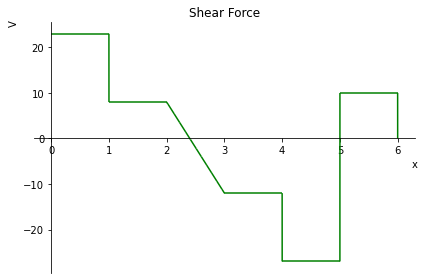

In [34]:
print("SHEAR FORCE DIAGRAM")
b.plot_shear_force()

In [35]:
print("BENDING MOMENT EQUATION")
b.bending_moment()

BENDING MOMENT EQUATION


23.0*SingularityFunction(x, 0.0, 1) - 15.0*SingularityFunction(x, 1.0, 1) - 10.0*SingularityFunction(x, 2.0, 2) + 10.0*SingularityFunction(x, 3.0, 2) - 15.0*SingularityFunction(x, 4.0, 1) + 37.0*SingularityFunction(x, 5.0, 1) - 10.0*SingularityFunction(x, 6.0, 1)

BENDING MOMENT DIAGRAM


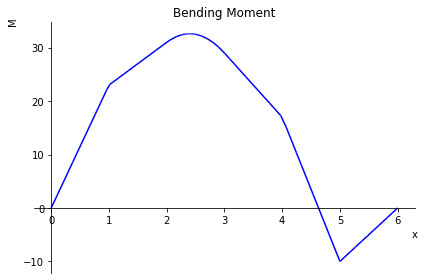

In [36]:
print('BENDING MOMENT DIAGRAM')
b.plot_bending_moment()